# 当代人工智能 Project2
## 卷积神经网络手写数字识别

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

导入TensorFlow和用于可视化的库

In [2]:
import pandas as pd

In [3]:
tf.__version__

'2.6.0'

实验开始前先取相应的数据集数据，做预处理

In [ ]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()
# 直接load mnist手写数字数据集，50000条训练，10000条测试
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
# 注意需要Padding，paddings=[[1,1],[1,1]]的意思是向上填充一行0，向下填充一行0，向左填充一行0，向右填充一行0，以此类推
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

In [4]:
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:]
y_train = y_train[:-2000]

11501568/11490434 [==============================] - 0s 0us/step


实现Inception模块，返回的张量为各分量的“聚合”

In [ ]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool):
  pth1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
  pth2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  pth2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(pth2)
  pth3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  pth3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(pth3)
  pth4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  pth4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pth4)
  # 使用concat来聚合不同卷积部分的结果
  return tf.concat([pth1, pth2, pth3, pth4], axis=3)

在Inception模块中，我们需要考虑3x3，5x5以及用于降维的1x1卷积块

In [ ]:
incep = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, 
                                                          interpolation="bilinear", #双线插值
                                                          input_shape=x_train.shape[1:])(incep)
                                            

In [ ]:
# 卷积，注意需要padding补0
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)

# 使用inception模块搭建GoogleNet，重复调用这个函数
x = inception(x,
              fil_1x1=64,
              fil_3x3_reduce=96,
              fil_3x3=128,
              fil_5x5_reduce=16,
              fil_5x5=32,
              fil_pool=32)

x = inception(x,
              fil_1x1=128,
              fil_3x3_reduce=128,
              fil_3x3=192,
              fil_5x5_reduce=32,
              fil_5x5=96,
              fil_pool=64)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              fil_1x1=192,
              fil_3x3_reduce=96,
              fil_3x3=208,
              fil_5x5_reduce=16,
              fil_5x5=48,
              fil_pool=64)

aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)

x = inception(x,
              fil_1x1=160,
              fil_3x3_reduce=112,
              fil_3x3=224,
              fil_5x5_reduce=24,
              fil_5x5=64,
              fil_pool=64)

x = inception(x,
              fil_1x1=128,
              fil_3x3_reduce=128,
              fil_3x3=256,
              fil_5x5_reduce=24,
              fil_5x5=64,
              fil_pool=64)

x = inception(x,
              fil_1x1=112,
              fil_3x3_reduce=144,
              fil_3x3=288,
              fil_5x5_reduce=32,
              fil_5x5=64,
              fil_pool=64)

# 此处需要实现辅助损失函数，辅助损失函数的作用是用于缓解梯度问题，具体解释请见实验报告的模型结构部分

aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 = layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2)
aux2 = layers.Dense(10, activation='softmax')(aux2)

x = inception(x,
              fil_1x1=256,
              fil_3x3_reduce=160,
              fil_3x3=320,
              fil_5x5_reduce=32,
              fil_5x5=128,
              fil_pool=128)

x = layers.MaxPooling2D(3, strides=2)(x)

x = inception(x,
              fil_1x1=256,
              fil_3x3_reduce=160,
              fil_3x3=320,
              fil_5x5_reduce=32,
              fil_5x5=128,
              fil_pool=128)

x = inception(x,
              fil_1x1=384,
              fil_3x3_reduce=192,
              fil_3x3=384,
              fil_5x5_reduce=48,
              fil_5x5=128,
              fil_pool=128)

x = layers.GlobalAveragePooling2D()(x) #使用GAP

x = layers.Dropout(0.4)(x) # 0.4,0.5
out = layers.Dense(10, activation='softmax')(x)

搭建Model，模型需要考虑
1. 主损失（我们训练的目标）
2. 辅助损失函数1
3. 辅助损失函数2

In [ ]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])
# 构建模型，需要注意辅助损失函数只是中间过程

调用adam优化器进行训练

In [ ]:
opt = 'adam' # rmsprop也可以

损失函数使用losses.sparse_categorical_crossentropy。sparse即真实的标签值以直接传入int类型的标签类别

In [ ]:
model.compile(optimizer='adam', loss=[losses.sparse_categorical_crossentropy, 
                                      losses.sparse_categorical_crossentropy, 
                                      losses.sparse_categorical_crossentropy], 
              # 损失需要加权
              loss_weights=[1, 0.3, 0.3], metrics=['accuracy']) # 主损失和auxiliary损失

开始训练，一共进行20个epoch的训练，BatchSize设定为64

In [ ]:
history = model.fit(x_train, [y_train, y_train, y_train], 
                    # 加载训练集和验证集
                    validation_data=(x_val, [y_val, y_val, y_val]), 
                    batch_size=64, epochs=20)

Epoch 1/20
907/907 [==============================] - 370s 367ms/step - loss: 1.2308 - dense_4_loss: 0.9021 - dense_1_loss: 0.5132 - dense_3_loss: 0.5826 - dense_4_accuracy: 0.6791 - dense_1_accuracy: 0.8263 - dense_3_accuracy: 0.8015 - val_loss: 0.1818 - val_dense_4_loss: 0.1370 - val_dense_1_loss: 0.0748 - val_dense_3_loss: 0.0746 - val_dense_4_accuracy: 0.9650 - val_dense_1_accuracy: 0.9795 - val_dense_3_accuracy: 0.9805
Epoch 2/20
907/907 [==============================] - 329s 363ms/step - loss: 0.2281 - dense_4_loss: 0.1584 - dense_1_loss: 0.1104 - dense_3_loss: 0.1219 - dense_4_accuracy: 0.9533 - dense_1_accuracy: 0.9658 - dense_3_accuracy: 0.9633 - val_loss: 0.0917 - val_dense_4_loss: 0.0645 - val_dense_1_loss: 0.0415 - val_dense_3_loss: 0.0494 - val_dense_4_accuracy: 0.9810 - val_dense_1_accuracy: 0.9905 - val_dense_3_accuracy: 0.9860
Epoch 3/20
907/907 [==============================] - 332s 366ms/step - loss: 0.1483 - dense_4_loss: 0.1000 - dense_1_loss: 0.0774 - dense_3_los

这里务必注意，两个辅助损失模块对我们的最终结果没有意义，我们只care主损失和其精确度，可以看到主损失在验证集上的准确度可以达到约99.5%，将这部分数据保存，再对其进行可视化

In [ ]:
pd.DataFrame(history.history).to_csv('mnist_training_log.csv', index=False)

In [5]:
history = pd.read_csv("mnist_training_log.csv")

可视化随着训练过程的进行，损失下降的情况

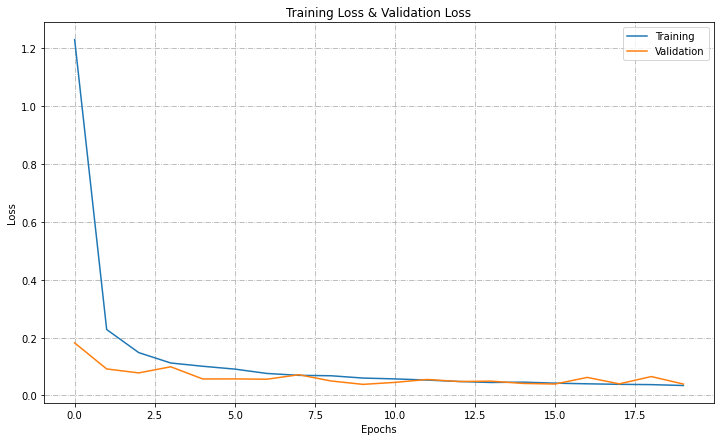

In [16]:
plt.gcf().set_size_inches(12, 7)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Training Loss & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(linestyle='-.')
plt.legend(['Training','Validation'])

可视化Accuracy

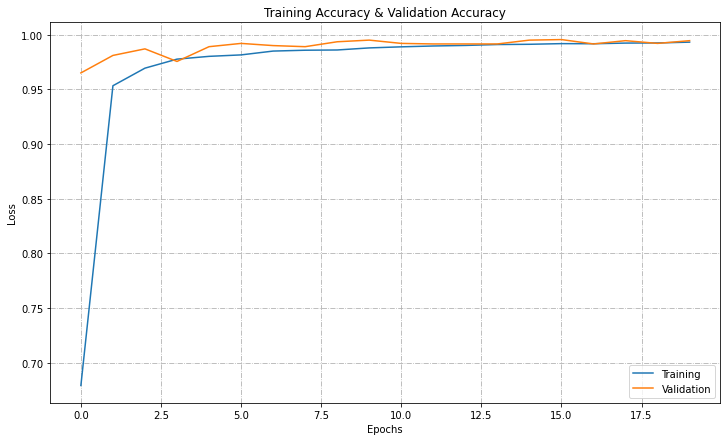

In [15]:
plt.gcf().set_size_inches(12, 7)
plt.plot(history['dense_4_accuracy'])
plt.plot(history['val_dense_4_accuracy'])
plt.title('Training Accuracy & Validation Accuracy')
plt.xlabel('Epochs')
plt.grid(linestyle='-.')
plt.ylabel('Loss')
plt.legend(['Training','Validation'])

随后在测试集上进行测试

In [ ]:
model.evaluate(x_test, y_test)